In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import datetime
import math
import matplotlib.pyplot as plt

In [2]:
data_path = './dataset/'
train = pd.read_csv(data_path + 'train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
test = pd.read_csv(data_path + 'test.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})
songs = pd.read_csv(data_path + 'songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv(data_path + 'members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')
print('Done loading...')

Done loading...


In [3]:
print('Data merging...')


train = train.merge(songs, on='song_id', how='left')
test = test.merge(songs, on='song_id', how='left')

members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)

members['registration_year'] = members['registration_init_time'].dt.year
members['registration_month'] = members['registration_init_time'].dt.month
members['registration_date'] = members['registration_init_time'].dt.day

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_date'] = members['expiration_date'].dt.day
members = members.drop(['registration_init_time'], axis=1)

Data merging...


In [4]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')

train = train.merge(songs_extra, on = 'song_id', how = 'left')
train.song_length.fillna(200000,inplace=True)
train.song_length = train.song_length.astype(np.uint32)
train.song_id = train.song_id.astype('category')


test = test.merge(songs_extra, on = 'song_id', how = 'left')
test.song_length.fillna(200000,inplace=True)
test.song_length = test.song_length.astype(np.uint32)
test.song_id = test.song_id.astype('category')

In [5]:
print('Done merging...')

Done merging...


In [6]:
print ("Adding new features")

def genre_id_count(x):
    if x == 'no_genre_id':
        return 0
    else:
        return x.count('|') + 1

train['genre_ids'].fillna('no_genre_id',inplace=True)
test['genre_ids'].fillna('no_genre_id',inplace=True)
train['genre_ids_count'] = train['genre_ids'].apply(genre_id_count).astype(np.int8)
test['genre_ids_count'] = test['genre_ids'].apply(genre_id_count).astype(np.int8)

def lyricist_count(x):
    if x == 'no_lyricist':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1
    return sum(map(x.count, ['|', '/', '\\', ';']))

train['lyricist'].fillna('no_lyricist',inplace=True)
test['lyricist'].fillna('no_lyricist',inplace=True)
train['lyricists_count'] = train['lyricist'].apply(lyricist_count).astype(np.int8)
test['lyricists_count'] = test['lyricist'].apply(lyricist_count).astype(np.int8)

def composer_count(x):
    if x == 'no_composer':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

train['composer'].fillna('no_composer',inplace=True)
test['composer'].fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(composer_count).astype(np.int8)
test['composer_count'] = test['composer'].apply(composer_count).astype(np.int8)

def is_featured(x):
    if 'feat' in str(x) :
        return 1
    return 0

train['artist_name'].fillna('no_artist',inplace=True)
test['artist_name'].fillna('no_artist',inplace=True)
train['is_featured'] = train['artist_name'].apply(is_featured).astype(np.int8)
test['is_featured'] = test['artist_name'].apply(is_featured).astype(np.int8)

def artist_count(x):
    if x == 'no_artist':
        return 0
    else:
        return x.count('and') + x.count(',') + x.count('feat') + x.count('&')

train['artist_count'] = train['artist_name'].apply(artist_count).astype(np.int8)
test['artist_count'] = test['artist_name'].apply(artist_count).astype(np.int8)

# if artist is same as composer
train['artist_composer'] = (train['artist_name'] == train['composer']).astype(np.int8)
test['artist_composer'] = (test['artist_name'] == test['composer']).astype(np.int8)


# if artist, lyricist and composer are all three same
train['artist_composer_lyricist'] = ((train['artist_name'] == train['composer']) & (train['artist_name'] == train['lyricist']) & (train['composer'] == train['lyricist'])).astype(np.int8)
test['artist_composer_lyricist'] = ((test['artist_name'] == test['composer']) & (test['artist_name'] == test['lyricist']) & (test['composer'] == test['lyricist'])).astype(np.int8)

# is song language 17 or 45. 
def song_lang_boolean(x):
    if '17.0' in str(x) or '45.0' in str(x):
        return 1
    return 0

train['song_lang_boolean'] = train['language'].apply(song_lang_boolean).astype(np.int8)
test['song_lang_boolean'] = test['language'].apply(song_lang_boolean).astype(np.int8)


_mean_song_length = np.mean(train['song_length'])
def smaller_song(x):
    if x < _mean_song_length:
        return 1
    return 0

train['smaller_song'] = train['song_length'].apply(smaller_song).astype(np.int8)
test['smaller_song'] = test['song_length'].apply(smaller_song).astype(np.int8)



Adding new features


In [7]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'city', 'bd', 'gender',
       'registered_via', 'expiration_date', 'membership_days',
       'registration_year', 'registration_month', 'registration_date',
       'expiration_year', 'expiration_month', 'song_year', 'genre_ids_count',
       'lyricists_count', 'composer_count', 'is_featured', 'artist_count',
       'artist_composer', 'artist_composer_lyricist', 'song_lang_boolean',
       'smaller_song'],
      dtype='object')

In [8]:
train_and_test = train.append(test, ignore_index=True)

_dict_song_first_appear_and_count = {}
_dict_artist_first_appear_and_count = {}

NORMARLIZATION_CONST = 5

def get_song_popularity(row):
    song_id = row['song_id']
    cur_row = row.name
    if song_id in _dict_song_first_appear_and_count:
        _dict_song_first_appear_and_count[song_id]['count'] += 1
        return  _dict_song_first_appear_and_count[song_id]['count'] / (cur_row - _dict_song_first_appear_and_count[song_id]['appear'] + NORMARLIZATION_CONST)
    else:
        _dict_song_first_appear_and_count[song_id] = {}
        _dict_song_first_appear_and_count[song_id]['appear'] = cur_row
        _dict_song_first_appear_and_count[song_id]['count'] = 1
        return 1 / NORMARLIZATION_CONST
    
train_and_test['song_popularity'] = train_and_test.apply(get_song_popularity, axis=1)
    

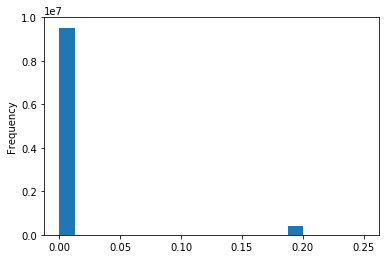

In [9]:
%matplotlib inline
plt.figure()
train_and_test['song_popularity'].plot.hist(bins=20)